In [1]:
%matplotlib inline

#                                     PROJECT COMPONENT 1

### Importing all the important libraries so that we dont need to call it again and again.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import pylab as pl
import math
import cartopy
import matplotlib.cm as cm
import seaborn as sns

### The first step of our approach is to import the transportable array into pandas for analysis

In [3]:
#loading the transportable array into pandas
array_vals = pd.read_csv("data-readonly/transportable_array/data_tohoku_norm_transpose.csv", header=None)

### Now as we see that the time ranges from 2:46 to 6:46, it would be better to get the time from 0:00 to 4:00 so as to use it for better indexing 

In [4]:
#normalisng the time to 0:00 to 4:00 for better usability
v = pd.date_range("2:46PM", "6:46PM", freq="1s")
v -= v[0]
array_vals["time"] = v
array_vals.set_index("time", inplace = True)

### This is a function to normalize the magnitude between 0 to 1, this is important so that all the magnitude values are between the range of 0 to 1, We have used min-max normalization to do the same, This function will be called whenever a data needs to be reduced to a range of 0 and 1

In [5]:
#Function to normalize the magnitude of the eathquake between 0 and 1
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result


### This is function to make a line plot showing the time as x-axis and magnitude as y-axis and the magnitude values are plotted, here the normalization takes place to keep all values between 0 to 1, so for plots of different magnitudes, the y-axis is fixed at 0 to 1 and does not keep chaging 

In [6]:
#Line plot for particular station
def g(y):
    global y1
    y1 = y
    a =plt.plot(array[y],color='orange') 
    plt.rcParams['figure.facecolor'] = 'white'
    plt.show()
    return a

### The file containing the lattitude and longitude is now loaded 

In [7]:
#loading the location.txt file into pandas which contain the latitude and longitude of the detector stations
locations = pd.read_csv("/srv/nbgrader/data/transportable_array/location.txt",
                        delimiter="\t", names =["longitude", "latitude", "a", "b"])
del locations["a"], locations["b"]

### This function calculates the haversine distance between 2 points, one point being the epicenter of the tohuku earthquake which is a fixed point while the 2nd point being the stations from the file containing latitude and longitude.

In [8]:
# Calculating the haversince distance
def distance(lat1, lon1,lat2,lon2): 
    
    radius = 6371 # km

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c

    return d

### Here we call the function to calculate the haversine distance  and then appending it to the locations dataframe

In [9]:
#function calls for calculating the haversine distance
a=[]
for i in range(0,len(locations)):
    a.append(distance(38.297,142.373,locations['latitude'][i],locations['longitude'][i]))
#Adding the column 'distance' to the location dataframe 
locations['distance'] = pd.DataFrame(a)

### We now sort the values based on the distance of all stations from the tohuku earthquake then we use those values from the locations dataframe to reorder the columns which are the station number in the array_vals dataframe

In [10]:
#sorting the locations based on the distance from the tohuku earthquake
locations =locations.sort_values('distance')
#setting columns based on distance paramter so the first column would 
#be the one closest to the tohoku location
array = pd.DataFrame(normalize(array_vals[locations.index.tolist()]))
#Taking transpose so now time are the columns
array1 = array.T


### This is a function to plot a spectogram of all the stations and all the times in the 2-D transportable array which shows us the data at whole in one frame, as for this we did the sorting of station based on distance

In [11]:
#Plotting the spectogram which shows the intensity of earthquake at all stations and all time(seconds)
def gg():
    plt.xlim(1500,3500)
    plt.imshow(array1,cmap=plt.get_cmap('hot_r'),origin='lower',aspect='auto')
    plt.colorbar()
    plt.show()

In [12]:
#Making a list of values from 0 to 437
stations_number=[]
for i in range(0,438):
    stations_number.append(i)
#Making a list of values from 0 to 14400
time = []
for i in range(0,14401):
    time.append(i)
array1.columns = time

### Here we are defining the canvas of the USA map using the cartopy library 

In [15]:
#Using cartopy to extract the shapes of the USA maps
states = cartopy.io.shapereader.natural_earth(resolution='110m', category='cultural',
                                    name='admin_1_states_provinces_lakes_shp')
#Defining a reader to read all the states 
reader =cartopy.io.shapereader.Reader(states)
#Contains all the information regarding all the states
all_states = list(reader.records())
#Creating a list that contains the visual shape of all the states 
geometries = [state.geometry for state in all_states]


### This is the function to make a the map which we deifined earlier by adding geometries and then overlaying the plots with the scatter plot which contains the locations of the stations

In [17]:
#Function to make a map and overlay it with the scatter plot 
#which chnages the color depending upon the magnitude of the earthquake
def f(x):
    #Getting individual columns corresponding to time x of the tohuku earthquake data frame
    y = array1[x]
    #generating 428 color map values 
    colors = cm.hot_r(y)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection = cartopy.crs.LambertConformal())
    ax.set_extent([-125, -68.5, 20, 50], cartopy.crs.Geodetic())
    #plotting the map 
    ax.add_geometries(geometries, crs=cartopy.crs.PlateCarree(), edgecolors='black',facecolor=[0.9375, 0.9375, 0.859375])
    for i in range(0,len(locations)):
        #plotting individual points with colors depending upon the magnitude value in the colors list
        ax.scatter(locations['longitude'][i], locations['latitude'][i],transform=cartopy.crs.Geodetic(),color = colors[i],edgecolor='k',zorder=1.5)
    #Generating the colorbar
    a = np.array([[0,1]])
    pl.figure(figsize=(10, 10))
    img = pl.imshow(a, cmap="hot_r")
    pl.gca().set_visible(False)
    pl.colorbar(orientation="horizontal")
    #pl.show()
    

interactive(children=(IntSlider(value=0, description='x', max=14000), Output()), _dom_classes=('widget-interact',))

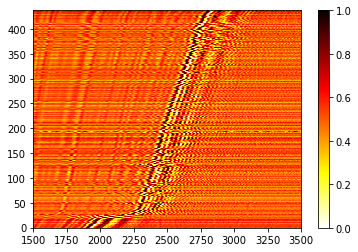

interactive(children=(IntSlider(value=0, description='y', max=437), Output()), _dom_classes=('widget-interact',))

<function __main__.g>

In [18]:
from ipywidgets import HBox
%matplotlib inline
interact(f,x=widgets.IntSlider(min=0,max=14000,step=1))
gg()
#Make line plot for the selected station between 0 to 438
interact(g,y=widgets.IntSlider(min=0,max=437,step=1))

## Approach

### Our approach was straightforward, first try to understand the basic functionalities which we had to code. so we started to first coding the individual elements such as map, line plot and spectogram and then later integrate all in one layout, the rest has been explained before each individual cell

## Strength

### The stregth of this code is the readability and the easeness of using matplotlib which is the most basic library for plotting different plots. The function written are very generalised, it can be used at differernt places without making much changes so it is replicable

## Weakness

### To be honest, while starting to code, I was not sure about what to use and what not to use, but it is not a wise choice to make a map in cartopy and different plots in matplotlib as to integrate both is an issue, my choice of using cartopy was because its code was there in lecture notes and it was easy to edit the code according to what i wanted rather use bqplot and google dumping its documentaion everytime i search something. Also it was almost impossible to integrate all these things into a subplot which i wasted considerable time rather than thinking of another solution

## what i wish i would do

### we would definetly not use cartopy and interact function, rather we would go ahead with bqplot as we now know what needs to be done, we would not use interact function and rather use observe which handles the function calling in a better way with more control with us. We were not able to do onlick and then change the lineplot rather than inputting the station number manually because as soon as we change the matplotlib to notebook python shakes down giving me a blank white screen which increased my frustration to limits at moments :P. The same problem did persist with annotate.
### To really blame someone for the project not 100% complete, MATPLOTLIB needs to be blamed. HAHA. although it works just fine with inline which for the matter of fact was of no use 

## Ending Remarks

### IT was a great experience to do a hands on project of data vizualisation. It not only taught about the concepts of data vizualisation but also about time management and also most importanty understanding the nature of the problem and then choosing its building component. 

### Even before doing a Visualisation project, Visualisation of what the building blocks would look like and what not to be used is very important. If i had more time I would do it again but after analysing what libraries to use in order to not get stuck in a deadlock. 